In [103]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from keras.datasets import mnist
from functools import partial
import matplotlib.pyplot as plt
import jax.random as random


In [104]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

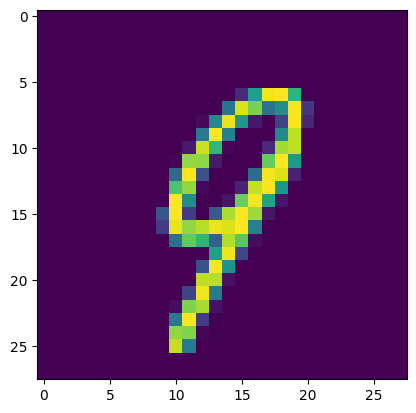

In [105]:
plt.imshow(train_X[22])
plt.show()

In [106]:
class Network(nn.Module):
    n_hidden: int
    n_output: int
    kernel_init: nn.initializers.Initializer = nn.initializers.xavier_uniform()

    @nn.compact
    def __call__(self, x):
        CustomDense = partial(nn.Dense, kernel_init=self.kernel_init)
        x = nn.relu(CustomDense(self.n_hidden)(x))
        x = nn.relu(CustomDense(self.n_hidden)(x))
        x = CustomDense(self.n_output)(x)
        return x
    


In [107]:
# @jax.jit
def update(model_state, x_batch, y_batch):

    def loss_fn(params): # Categorical loss
        pred = model_state.apply_fn(params, x_batch)
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, y_batch).mean()
        return loss #jnp.mean(-pred[y_batch])

    loss_value, grad = jax.value_and_grad(loss_fn)(model_state.params)
    model_state = model_state.apply_gradients(grads=grad)
    return loss_value, model_state

In [108]:
lr = 5e-5
n_output = 10
n_hidden = 16
img_size = 28*28

rng = random.PRNGKey(0)
key, rng = random.split(rng)

model = Network(n_hidden, n_output)
# model_state = create_trainstate(key, model, lr, n_output)
input_shape = (1, img_size)
params = model.init(key, jnp.zeros(input_shape))
model_state = TrainState.create(apply_fn=jax.jit(model.apply),
                                params=params,
                                tx=optax.adam(lr))
input_shape

(1, 784)

In [109]:
# jnp.sum(model_state.apply_fn(params, ex_img))

train_X (1200, 50, 784)
train_y (1200, 50)
test_X2 (10000, 784)
test_y2 (10000,)
Epoch: 0 test loss: 0.7581084370613098
Epoch: 1 test loss: 0.7004231214523315
Epoch: 2 test loss: 0.6539474725723267
Epoch: 3 test loss: 0.6095278263092041
Epoch: 4 test loss: 0.5567154288291931
Epoch: 5 test loss: 0.46468037366867065
Epoch: 6 test loss: 0.4116400480270386
Epoch: 7 test loss: 0.36691516637802124


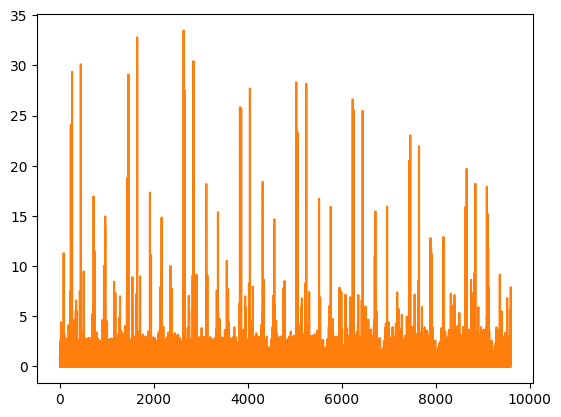

In [142]:
epochs = 8
batch_size = 50

train_X2 = train_X.reshape((train_X.shape[0]//batch_size, batch_size, img_size))
train_y2 = train_y.reshape((train_y.shape[0]//batch_size, batch_size))
test_X2 = test_X.reshape((-1, img_size))
test_y2 = test_y
# test_y2 = test_y.reshape((test_y.shape[0]//batch_size, batch_size))

print("train_X", train_X2.shape)
print("train_y", train_y2.shape)
print("test_X2", test_X2.shape)
print("test_y2", test_y2.shape)

losses = []
test_losses = []

for epoch in range(epochs):
    for x_batch, y_batch, x_test, y_test in zip(train_X2, train_y2, test_X2, test_y2):
        loss_value, model_state = update(model_state, x_batch, y_batch)
        test_loss_value, _ = update(model_state, x_test, y_test)
        
        losses.append(loss_value)
        test_losses.append(test_loss_value)
    print(f"Epoch: {epoch} test loss: {np.mean(losses[-len(x_batch):])}")

plt.plot(losses)
plt.plot(test_losses)
plt.show()

[[ 0.10393031 -0.36263317 -0.10372828 -0.19992925  3.3434947   1.3641169
   1.6075102   0.3417971   1.3149753   1.978538  ]]
92 [4]


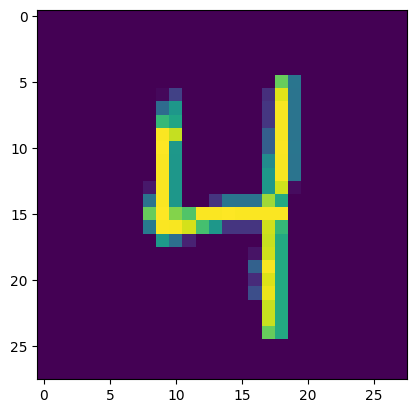

In [143]:
img_idx = np.random.randint(100)
ex_img = jnp.expand_dims(train_X[img_idx].flatten(), axis=0)
logits = model_state.apply_fn(model_state.params, ex_img)

print(logits)
print(img_idx, jnp.argmax(logits, axis=-1))

plt.imshow(train_X[img_idx])
plt.show()

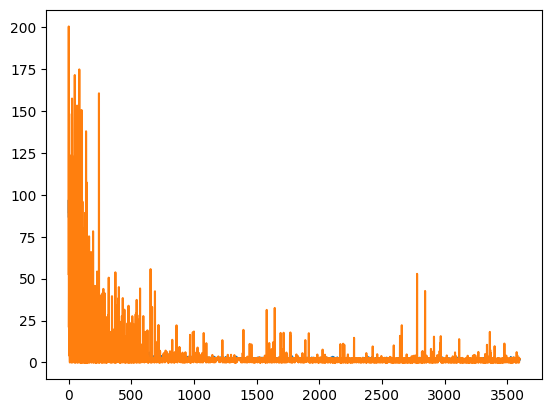

In [112]:
# test loss
# test_losses = []

# for x_batch, y_batch in zip(test_X2, test_y2):
#     test_loss_value, _ = update(model_state, x_batch, y_batch)
#     test_losses.append(test_loss_value)

plt.plot(losses)
plt.plot(test_losses)
plt.show()